# RQ1 How long it took developers to adopt safetensors after its first release?

Goal is to check when safetensors was first used in each studied repository.    

## Read the data first

In [45]:
from nb_utils import read_commits

# model files per repository and the elapsed days between the commit and safetensor's release date
df = read_commits()

# Filter out rows with 'safetensors' serialization format
df_safetensors = df[df['serialization_format'] == 'safetensors']
df_safetensors

,repo_url,commit_hash,model_file_path,serialization_format,message,author,date,elapsed_days
0,rinna/japanese-gpt-neox-small,f33d44540298e143079f34c35b21eebe4f3dce89,model.safetensors,safetensors,Adding `safetensors` variant of this model (#2...,Tianyu Zhao,2023-08-04 06:46:32,315
7,recogna-nlp/ptt5-base-summ-cstnews,f19cd2be31b69c2ade92a3ad83bca1b59d927560,model.safetensors,safetensors,Adding `safetensors` variant of this model (#1...,Pedro Henrique Paiola,2023-03-21 23:42:48,179
10,recogna-nlp/ptt5-base-summ-temario,5d2adb7176cab93a8994c35d7fb6ba0ffcd22638,model.safetensors,safetensors,Adding `safetensors` variant of this model (#1...,Pedro Henrique Paiola,2023-03-21 23:42:24,179
13,recogna-nlp/ptt5-base-summ-xlsum,f12939f002bfa15523990152fbb590ca5633ef69,model.safetensors,safetensors,Adding `safetensors` variant of this model (#1...,Pedro Henrique Paiola,2023-03-21 23:41:42,179
16,recogna-nlp/ptt5-base-summ-wikilingua,c357f46f7de558dfe207037f71f8b6cee1359e38,model.safetensors,safetensors,Adding `safetensors` variant of this model (#1...,Pedro Henrique Paiola,2023-05-20 18:27:11,239
...,...,...,...,...,...,...,...,...
8116,EleutherAI/gpt-neox-20b,007b5cbc9ca9d293dcfe3f96b48bec6d03d87537,model-00043-of-00046.safetensors,safetensors,Adding `safetensors` variant of this model (#1...,Stella Biderman,2023-02-07 01:46:15,137
8117,EleutherAI/gpt-neox-20b,007b5cbc9ca9d293dcfe3f96b48bec6d03d87537,model-00044-of-00046.safetensors,safetensors,Adding `safetensors` variant of this model (#1...,Stella Biderman,2023-02-07 01:46:15,137
8118,EleutherAI/gpt-neox-20b,007b5cbc9ca9d293dcfe3f96b48bec6d03d87537,model-00045-of-00046.safetensors,safetensors,Adding `safetensors` variant of this model (#1...,Stella Biderman,2023-02-07 01:46:15,137
8119,EleutherAI/gpt-neox-20b,007b5cbc9ca9d293dcfe3f96b48bec6d03d87537,model-00046-of-00046.safetensors,safetensors,Adding `safetensors` variant of this model (#1...,Stella Biderman,2023-02-07 01:46:15,137


## Analysis 1: How many commits containing safetensors files were made by the SFconvertbot?

HuggingFace has a bot (https://huggingface.co/SFconvertbot) that converts models to safetensors.
How many commits were made by the bot and how many were made by developers themselves?
Hugging Face bot's source code: https://github.com/huggingface/safetensors/commits/main/bindings/python/convert.py

In [46]:
from nb_utils import RESULTS_DIR
import pandas as pd

stats = pd.Series()
# check if the message contains the bot message
bot_message = "Adding `safetensors` variant of this model"
df_safetensors_not_by_bot = df_safetensors[~df_safetensors['message'].str.contains(bot_message)]
df_safetensors_by_bot = df_safetensors[df_safetensors['message'].str.contains(bot_message)]


# compute number of unique repo_url and commit_hash combination in df
num_commits = len(df[['repo_url', 'commit_hash']].drop_duplicates())
num_safetensors_commits = len(df_safetensors[['repo_url', 'commit_hash']].drop_duplicates())
num_safetensors_commits_by_bot = len(df_safetensors_by_bot[['repo_url', 'commit_hash']].drop_duplicates())
num_safetensors_commits_not_by_bot = len(df_safetensors_not_by_bot[['repo_url', 'commit_hash']].drop_duplicates())

# Compute some more statistics to be saved
stats.loc['# repos'] = len(df['repo_url'].unique())
stats.loc['# commits'] = num_commits
stats.loc['# commits touching safetensor files'] = num_safetensors_commits
stats.loc['# commits made by the bot'] = num_safetensors_commits_by_bot
stats.loc['% commits made by the bot'] = num_safetensors_commits_by_bot / num_safetensors_commits * 100
stats.loc['# commits made by developers'] = num_safetensors_commits_not_by_bot
stats.loc['% commits made by developers'] = num_safetensors_commits_not_by_bot / num_safetensors_commits * 100
stats.loc['min elapsed days'] = df_safetensors['elapsed_days'].min()
stats.loc['quartile2 elapsed days'] = df_safetensors['elapsed_days'].quantile(0.25)
stats.loc['median elapsed days'] = df_safetensors['elapsed_days'].median()
stats.loc['quartile4 elapsed days'] = df_safetensors['elapsed_days'].quantile(0.75)
stats.loc['max elapsed days'] = df_safetensors['elapsed_days'].max()
stats.loc['date with max number of adoptions'] = str(df_safetensors[df_safetensors['elapsed_days'] == df_safetensors['elapsed_days'].mode().values[0]].iloc[0]['date']).split(" ")[0]
stats.to_csv(RESULTS_DIR / 'rq1_dataset_stats.csv',  header=False)




df_safetensors_not_by_bot.to_csv(RESULTS_DIR / 'safetensors_commits_not_by_bot.csv', index=False)
df_safetensors_by_bot.to_csv(RESULTS_DIR / 'safetensors_commits_by_bot.csv', index=False)

## Analysis 2: Number of elapsed days since the release of safetensors

This script checks how long it took safetensors to first appear in each analyzed repository.

In [47]:
df_safetensors_first_appearance = df_safetensors.groupby('repo_url')['elapsed_days'].min().sort_values()
df_safetensors_first_appearance

repo_url
FacebookAI/roberta-large                             6
openai-community/gpt2                                6
FacebookAI/roberta-base                              6
distilbert/distilgpt2                               52
google-bert/bert-large-uncased                      52
                                                  ... 
nateraw/vit-age-classifier                         674
bhadresh-savani/distilbert-base-uncased-emotion    691
deepmind/optical-flow-perceiver                    703
SI2M-Lab/DarijaBERT                                733
Kamel/t5-darija-summarization                      733
Name: elapsed_days, Length: 417, dtype: int64

## Analysis 3: Plot the number of adoptions per elapsed days

Since the first safetensors release, shows the number of model files using safetensors per elapsed days.

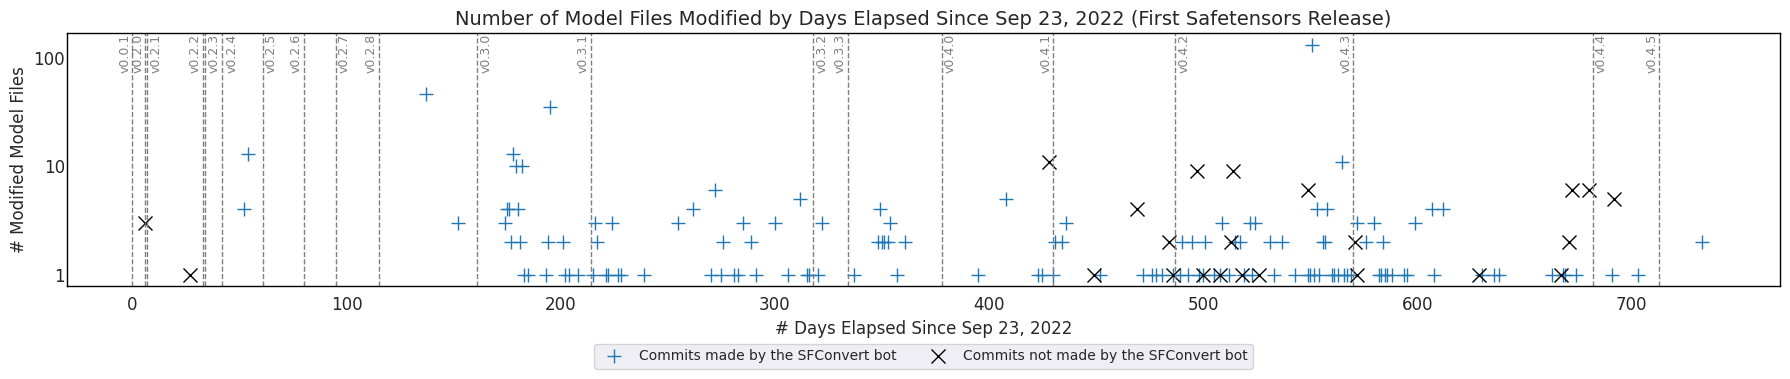

In [48]:
from pathlib import Path
import matplotlib.pyplot as plt
from nb_utils import get_safetensors_releases, SAFETENSORS_RELEASE_DATE

# Group by elapsed days to count files modified on each date
all_commits = df_safetensors['elapsed_days'].value_counts().sort_index()
commits_not_by_bot = df_safetensors_not_by_bot['elapsed_days'].value_counts().sort_index()
commits_by_bot = df_safetensors_by_bot['elapsed_days'].value_counts().sort_index()

# Plotting
plt.figure(figsize=(18,4), facecolor="white")  # Set figure background to white
ax = plt.gca()  # Get the current axis
ax.set_facecolor("white")  # Set axis background to white

# Ensure the visibility of x-axis and y-axis lines (spines)
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(1.0)


plt.plot(commits_by_bot.index, commits_by_bot.values, 
         marker='+', linestyle='None', markersize=10,  label="Commits made by SFConvert bot")
plt.plot(commits_not_by_bot.index, commits_not_by_bot.values, 
         marker='x', linestyle='None', color='black', markersize=10, label="Commits not made by SFConvert bot")

plt.xlabel("# Days Elapsed Since Sep 23, 2022", fontsize=12)
plt.ylabel("# Modified Model Files", fontsize=12)
plt.title("Number of Model Files Modified by Days Elapsed Since Sep 23, 2022 (First Safetensors Release)", fontsize=14)
plt.yscale('log')
plt.yticks([1, 10, 100], ['1', '10', '100'], fontsize=12)
plt.xticks(fontsize=12)
plt.grid(True)
plt.legend(
    ('Commits made by the SFConvert bot','Commits not made by the SFConvert bot'),
    loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2, fontsize=10)
plt.tight_layout()


df_releases  = get_safetensors_releases()

#  add vertical lines for each release date with labels
color, i, x_coordinates = 'tab:gray', 0, [1, -6.5]

for day, label in df_releases[['date', 'tag']].values:
    i = (i + 1) % 2
    diff = (day - SAFETENSORS_RELEASE_DATE).days
    plt.axvline(x=diff,color=color, linestyle='--', linewidth=1)
    x_offset = 1.5 if label == 'v0.2.4' else  x_coordinates[i]
    plt.text(diff + x_offset, plt.ylim()[1] * 0.99, label, color=color, rotation=90, verticalalignment='top', fontdict={'size':9.0})
    if label == 'v0.0.1': i = 2


# Save the plot as a PDF file
plt.savefig(Path('../../results/RQ1CommitsDistribution.pdf'), format="pdf", bbox_inches="tight")

plt.show()

## Analysis 4: Number of adoptions as heatmap

C:\Users\Matt\.virtualenvs\wip-model-evolution-AEl__IAV\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 108 (l) missing from font(s) Noto Emoji.
  fig.canvas.draw()
C:\Users\Matt\.virtualenvs\wip-model-evolution-AEl__IAV\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 112 (p) missing from font(s) Noto Emoji.
  fig.canvas.draw()


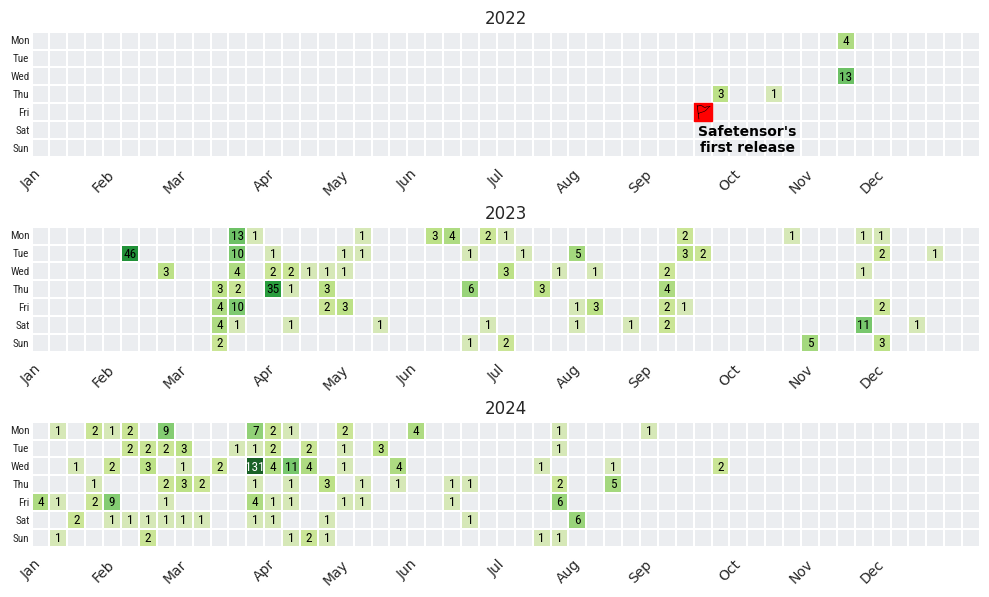

In [49]:

import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd
import warnings
from pathlib import Path
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt



# Create a font property with Noto Emoji and Roboto Condensed fonts
emoji_font = FontProperties(fname=Path('../../assets/NotoEmoji-Regular.ttf'))
color_emoji_font = FontProperties(fname=Path('../../assets/NotoColorEmoji-Regular.ttf'))
roboto_condensed_font = FontProperties(fname=Path('../../assets/RobotoCondensed-Regular.ttf'))
                            
# Set a different font with broad Unicode support
plt.rcParams['font.family'] = 'DejaVu Sans' 
# Decrease padding for y-axis tick labels
plt.rcParams['ytick.major.pad'] = -2  # Decrease this value as needed


# group by timestamp, and ignore the times, just group based on the date
commits_by_date = df_safetensors.groupby(df_safetensors['date'].dt.floor('D')).size().sort_index()

# add all dates from SAFE TENSORS RELEASE DATE to today
for i in range(0, (pd.Timestamp.today() - SAFETENSORS_RELEASE_DATE).days):
    date = SAFETENSORS_RELEASE_DATE + pd.Timedelta(days=i)
    if date not in commits_by_date.index:
        commits_by_date.loc[date] = 0
commits_by_date = commits_by_date.sort_index()
# name the count as 'count'
commits_by_date.name = 'count'

# Ensure 'files_modified_by_date' has datetime as the index if not already
commits_by_date.index = pd.to_datetime(commits_by_date.index)

# Define the years for which we want to create heatmaps
years = [2022, 2023, 2024]

# Define a color map similar to GitHub's green color scheme
colors = ["#ebedf0", "#c6e48b", "#7bc96f", "#239a3b", "#196127"]
cmap = LinearSegmentedColormap.from_list("github_green", colors)

# Determine the maximum value across the entire dataset to set a common color range
vmax = commits_by_date.max()

# Apply a log transformation to the commits, offsetting by 1 to handle zero values
log_commits_by_date = np.log1p(commits_by_date)  # log(1 + count)

# Determine the max log-transformed value for setting the consistent color range
vmax_log = log_commits_by_date.max()

# Modify the function to add count annotations on non-zero cells

def plot_year_heatmap_with_annotations(year, ax):
    # Create a DataFrame with dates for the specified year and apply log-transformed data
    year_data = log_commits_by_date[log_commits_by_date.index.year == year]
    year_data_original = commits_by_date[commits_by_date.index.year == year]  # Original counts for annotation
    year_data = year_data.reindex(pd.date_range(f"{year}-01-01", f"{year}-12-31"), fill_value=0)
    year_data_original = year_data_original.reindex(pd.date_range(f"{year}-01-01", f"{year}-12-31"), fill_value=0)

    # Create a matrix for days (rows) and weeks (columns) for a horizontal layout
    year_matrix = np.zeros((7, 53))
    year_matrix_original = np.zeros((7, 53))

    for i, (date, value) in enumerate(year_data.items()):
        week = date.isocalendar().week - 1
        day = date.weekday()
        year_matrix[day, week] = value
        year_matrix_original[day, week] = year_data_original[date]  # Original count for annotation

    # Plot the heatmap with log-transformed data
    sns.heatmap(year_matrix, ax=ax, cmap=cmap, cbar=False,
                vmin=0, vmax=vmax_log, linewidths=0.1, linecolor='white', square=True,
                yticklabels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

    # Add annotations for non-zero values
    for row in range(7):
        for col in range(53):
            if year_matrix_original[row, col] > 0:
                ax.text(col + 0.5, row + 0.5, f"{int(year_matrix_original[row, col])}",
                        ha='center', va='center', fontsize=9.5, color='black' if year_matrix_original[row, col] < vmax else 'white', fontproperties=roboto_condensed_font)
                

    # Set title and adjust labels for horizontal orientation
    ax.set_title(f"{year}")
    ax.set_yticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
    # # set font family for the labels
    for label in ax.get_yticklabels():
        label.set_fontproperties(roboto_condensed_font)
        #change font size
        label.set_fontsize(8)
        # make label as close as possible to chart
        label.set_verticalalignment('center')
        # decrease padding
        # label.set_pad(0)
    # 
    # Adjust the month labels along the x-axis
    month_ticks = [0, 4, 8, 13, 17, 21, 26, 30, 34, 39, 43, 47]
    ax.set_xticks(month_ticks)
    ax.set_xticklabels([calendar.month_abbr[i] for i in range(1, 13)], rotation=45)
    
    if year == 2022:
        # Define the day and week position to highlight
        highlight_day = 4  # Example: 2 for Wednesday
        highlight_week = 37  # Example week to highlight
        # Add a red patch to highlight the selected square
        ax.add_patch(Rectangle((highlight_week, highlight_day), 1, 1, fill=True, color="red"))
        # Add a text annotation to highlight the selected square
        ax.text(highlight_week + 3, highlight_day + 2, "Safetensor's\nfirst release", ha='center', va='center', color="black", fontsize=10, weight='bold')       
        # Add a vertical line to highlight the selected week
        ax.text(highlight_week + 0.5, highlight_day + 0.5, "🚩", fontproperties=emoji_font,
                        ha='center', va='center', fontsize=10, color='black' )
         

# Plot horizontal heatmaps with annotations for non-zero values
fig, axes = plt.subplots(len(years), 1, figsize=(10, 6))

for i, year in enumerate(years):
    plot_year_heatmap_with_annotations(year, axes[i])

plt.tight_layout()




with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plt.savefig(Path('../../results/RQ1Heatmap.pdf'), bbox_inches='tight', format='pdf')
    plt.savefig(Path('../../results/RQ1Heatmap.png'), bbox_inches='tight', format='png')
    # save as svg
    plt.savefig(Path('../../results/RQ1Heatmap.svg'), bbox_inches='tight', format='svg')
    plt.show()


In [50]:
commits_by_date

date
2022-09-23    0
2022-09-24    0
2022-09-25    0
2022-09-26    0
2022-09-27    0
             ..
2024-10-29    0
2024-10-30    0
2024-10-31    0
2024-11-01    0
2024-11-02    0
Name: count, Length: 772, dtype: int64

# ATEMPT 1

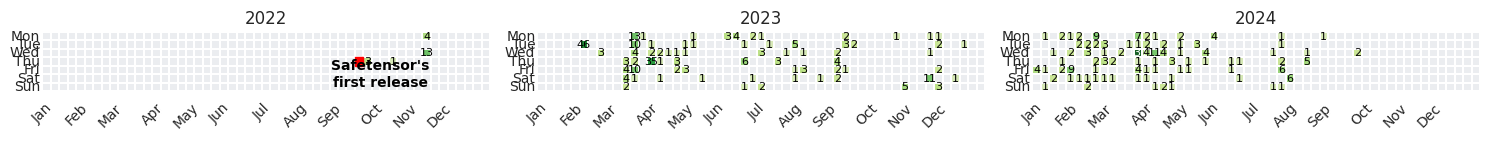

In [51]:

import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Define the years for which we want to create heatmaps
years = [2022, 2023, 2024]

# Define a color map similar to GitHub's green color scheme
colors = ["#ebedf0", "#c6e48b", "#7bc96f", "#239a3b", "#196127"]
cmap = LinearSegmentedColormap.from_list("github_green", colors)

# Determine the maximum value across the entire dataset to set a common color range
vmax = commits_by_date.max()

# Apply a log transformation to the commits, offsetting by 1 to handle zero values
log_commits_by_date = np.log1p(commits_by_date)  # log(1 + count)

# Determine the max log-transformed value for setting the consistent color range
vmax_log = log_commits_by_date.max()

# Modify the function to add count annotations on non-zero cells

def plot_year_heatmap_with_annotations(year, ax):
    # Create a DataFrame with dates for the specified year and apply log-transformed data
    year_data = log_commits_by_date[log_commits_by_date.index.year == year]
    year_data_original = commits_by_date[commits_by_date.index.year == year]  # Original counts for annotation
    year_data = year_data.reindex(pd.date_range(f"{year}-01-01", f"{year}-12-31"), fill_value=0)
    year_data_original = year_data_original.reindex(pd.date_range(f"{year}-01-01", f"{year}-12-31"), fill_value=0)

    # Create a matrix for days (rows) and weeks (columns) for a horizontal layout
    year_matrix = np.zeros((7, 53))
    year_matrix_original = np.zeros((7, 53))

    for i, (date, value) in enumerate(year_data.items()):
        week = date.isocalendar().week - 1
        day = date.weekday()
        year_matrix[day, week] = value
        year_matrix_original[day, week] = year_data_original[date]  # Original count for annotation

    # Plot the heatmap with log-transformed data
    sns.heatmap(year_matrix, ax=ax, cmap=cmap, cbar=False,
                vmin=0, vmax=vmax_log, linewidths=0.1, linecolor='white', square=True,
                yticklabels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

    # Add annotations for non-zero values
    for row in range(7):
        for col in range(53):
            if year_matrix_original[row, col] > 0:
                ax.text(col + 0.5, row + 0.5, f"{int(year_matrix_original[row, col])}",
                        ha='center', va='center', fontsize=8, color='black' if year_matrix_original[row, col] < vmax else 'white')
                

    # Set title and adjust labels for horizontal orientation
    ax.set_title(f"{year}")
    ax.set_yticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
    
    # Adjust the month labels along the x-axis
    month_ticks = [0, 4, 8, 13, 17, 21, 26, 30, 34, 39, 43, 47]
    ax.set_xticks(month_ticks)
    ax.set_xticklabels([calendar.month_abbr[i] for i in range(1, 13)], rotation=45)
    
    if year == 2022:
        highlight_day = 3  # Friday
        highlight_week = 37  # Week when September 23 falls
        # Highlight Safetensors' first release
        ax.add_patch(Rectangle((highlight_week, highlight_day), 1, 1, fill=True, color="red"))
        ax.text(highlight_week + 3, highlight_day + 2, "Safetensor's\nfirst release", ha='center', va='center', color="black", fontsize=10, weight='bold')       

# Plot horizontal heatmaps for each year side by side
fig, axes = plt.subplots(1, len(years), figsize=(15, 6))

for i, year in enumerate(years):
    plot_year_heatmap_with_annotations(year, axes[i])

plt.tight_layout()
plt.show()


# ATEMPT 2


In [ ]:
# Adjust the start date for 2022 to begin on September 20 for the heatmap display

def plot_year_heatmap_with_custom_start(year, ax, start_date=None):
    # Define the range for each year, starting from the custom date if specified
    if start_date:
        year_data = log_commits_by_date[(log_commits_by_date.index >= start_date) & (log_commits_by_date.index.year == year)]
        year_data_original = commits_by_date[(commits_by_date.index >= start_date) & (commits_by_date.index.year == year)]
        end_date = f"{year}-12-31"
    else:
        year_data = log_commits_by_date[log_commits_by_date.index.year == year]
        year_data_original = commits_by_date[commits_by_date.index.year == year]
        end_date = f"{year}-12-31"
    
    # Reindex to fill missing dates
    year_data = year_data.reindex(pd.date_range(start=start_date or f"{year}-01-01", end=end_date), fill_value=0)
    year_data_original = year_data_original.reindex(pd.date_range(start=start_date or f"{year}-01-01", end=end_date), fill_value=0)

    # Create a matrix for days (rows) and weeks (columns) for a horizontal layout
    num_weeks = 53  # Adjust weeks to cover part of a year as needed
    year_matrix = np.zeros((7, num_weeks))
    year_matrix_original = np.zeros((7, num_weeks))

    for date, value in year_data.items():
        week = date.isocalendar().week - 1
        day = date.weekday()
        year_matrix[day, week] = value
        year_matrix_original[day, week] = year_data_original[date]  # Original count for annotation

    # Plot the heatmap with log-transformed data
    sns.heatmap(year_matrix, ax=ax, cmap=cmap, cbar=False,
                vmin=0, vmax=vmax_log, linewidths=0.1, linecolor='white', square=True,
                yticklabels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

    # Add annotations for non-zero values
    for row in range(7):
        for col in range(num_weeks):
            if year_matrix_original[row, col] > 0:
                ax.text(col + 0.5, row + 0.5, f"{int(year_matrix_original[row, col])}",
                        ha='center', va='center', fontsize=8, color='black' if year_matrix_original[row, col] < vmax else 'white')
                
    # Set title and adjust labels for horizontal orientation
    ax.set_title(f"{year}")
    ax.set_yticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
    
    # Adjust the month labels along the x-axis
    month_ticks = [0, 4, 8, 13, 17, 21, 26, 30, 34, 39, 43, 47]
    ax.set_xticks(month_ticks)
    ax.set_xticklabels([calendar.month_abbr[i] for i in range(1, 13)], rotation=45)
    
    if year == 2022:
        highlight_day = 1  # Tuesday
        highlight_week = 37  # Week when September 20 falls
        # Highlight Safetensors' first release
        ax.add_patch(Rectangle((highlight_week, highlight_day), 1, 1, fill=True, color="red"))
        ax.text(highlight_week + 3, highlight_day + 2, "Safetensor's\nfirst release", ha='center', va='center', color="black", fontsize=10, weight='bold')       

# Plot horizontal heatmaps for each year side by side with custom start date for 2022
fig, axes = plt.subplots(1, len(years), figsize=(15, 6))

for i, year in enumerate(years):
    if year == 2022:
        plot_year_heatmap_with_custom_start(year, axes[i], start_date="2022-09-20")
    else:
        plot_year_heatmap_with_custom_start(year, axes[i])

plt.tight_layout()
plt.show()

# ATEMPT 3

C:\Users\Matt\.virtualenvs\wip-model-evolution-AEl__IAV\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 108 (l) missing from font(s) Noto Emoji.
  fig.canvas.draw()
C:\Users\Matt\.virtualenvs\wip-model-evolution-AEl__IAV\lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 112 (p) missing from font(s) Noto Emoji.
  fig.canvas.draw()
C:\Users\Matt\AppData\Local\Temp\ipykernel_25584\284583554.py:119: UserWarning: Glyph 108 (l) missing from font(s) Noto Emoji.
  plt.savefig(Path('../../results/Attempt3.pdf'), bbox_inches='tight', format='pdf')
C:\Users\Matt\AppData\Local\Temp\ipykernel_25584\284583554.py:119: UserWarning: Glyph 112 (p) missing from font(s) Noto Emoji.
  plt.savefig(Path('../../results/Attempt3.pdf'), bbox_inches='tight', format='pdf')
C:\Users\Matt\.virtualenvs\wip-model-evolution-AEl__IAV\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 108 (l) missing from font(s) Noto Emoji.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Matt\.vir

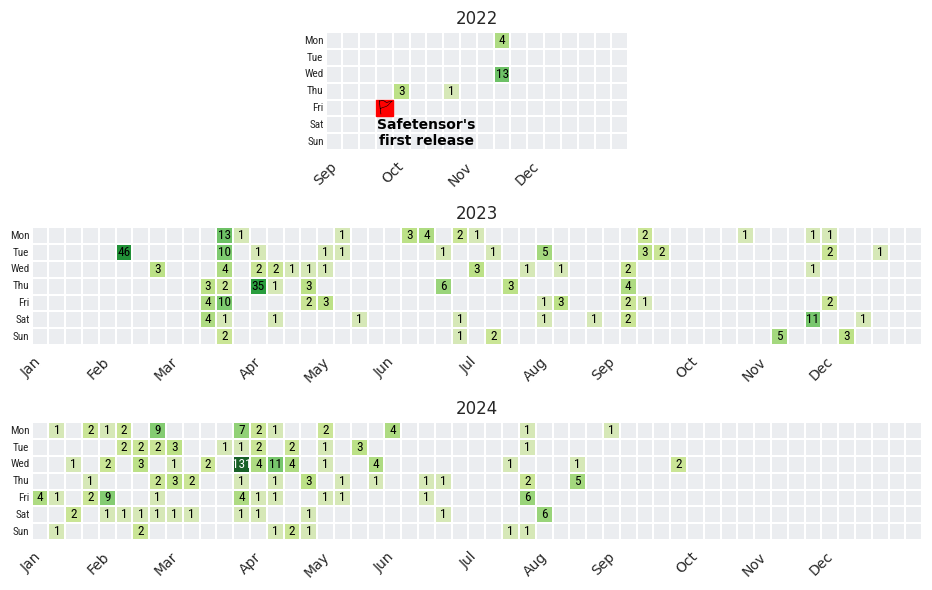

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
from matplotlib.colors import LinearSegmentedColormap
from pathlib import Path
import numpy as np


# Create a font property with Noto Emoji and Roboto Condensed fonts
emoji_font = FontProperties(fname=Path('../../assets/NotoEmoji-Regular.ttf'))
color_emoji_font = FontProperties(fname=Path('../../assets/NotoColorEmoji-Regular.ttf'))
roboto_condensed_font = FontProperties(fname=Path('../../assets/RobotoCondensed-Regular.ttf'))
                            
# Set a different font with broad Unicode support
plt.rcParams['font.family'] = 'DejaVu Sans' 
# Decrease padding for y-axis tick labels
plt.rcParams['ytick.major.pad'] = -2  # Decrease this value as needed




# Define the years for which we want to create heatmaps
years = [2022, 2023, 2024]

# Define a color map similar to GitHub's green color scheme
colors = ["#ebedf0", "#c6e48b", "#7bc96f", "#239a3b", "#196127"]
cmap = LinearSegmentedColormap.from_list("github_green", colors)

# Determine the maximum value across the entire dataset to set a common color range
vmax = commits_by_date.max()
vmin = commits_by_date.min()
# Apply a log transformation to the commits, offsetting by 1 to handle zero values
log_commits_by_date = np.log1p(commits_by_date)  # log(1 + count)

# Determine the max log-transformed value for setting the consistent color range
vmax_log = log_commits_by_date.max()

# Modify the function to add count annotations on non-zero cells

def plot_year_heatmap_with_custom_start_fixed(year, ax, start_month=None):
    # Define start date for each year
    if year == 2022 and start_month is not None:
        start_date = f"{year}-{start_month:02d}-01"
    else:
        start_date = f"{year}-01-01"
    end_date = f"{year}-12-31"

    # Create a DataFrame with dates for the specified range
    year_data = log_commits_by_date[start_date:end_date]
    year_data_original = commits_by_date[start_date:end_date]  # Original counts for annotation

    # Calculate the number of weeks from the adjusted start date to the end of the year
    weeks_in_range = (pd.Timestamp(end_date) - pd.Timestamp(start_date)).days // 7 + 1
    year_matrix = np.zeros((7, weeks_in_range))
    year_matrix_original = np.zeros((7, weeks_in_range))

    for i, (date, value) in enumerate(year_data.items()):
        week = (date - pd.Timestamp(start_date)).days // 7  # Adjust week index from start_date
        day = date.weekday()
        year_matrix[day, week] = value
        year_matrix_original[day, week] = year_data_original[date]  # Original count for annotation

    # Plot the heatmap with log-transformed data
    sns.heatmap(year_matrix, ax=ax, cmap=cmap, cbar=False,
                vmin=0, vmax=vmax_log, linewidths=0.1, linecolor='white', square=True,
                yticklabels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

    # Add annotations for non-zero values
    for row in range(7):
        for col in range(weeks_in_range):
            if year_matrix_original[row, col] > 0:
                ax.text(col + 0.5, row + 0.5, f"{int(year_matrix_original[row, col])}",
                        ha='center', va='center', fontsize=9.5, color='black' if year_matrix_original[row, col] < vmax else 'white', fontproperties=roboto_condensed_font)

    # Set title and adjust labels for horizontal orientation
    ax.set_title(f"{year}")
    ax.set_yticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
    # set font family for the labels
    for label in ax.get_yticklabels():
        label.set_fontproperties(roboto_condensed_font)
        label.set_fontsize(8)
        label.set_verticalalignment('center')
        
    # Adjust the month labels along the x-axis for the selected range
    if year == 2022:
        month_ticks = [0, 4, 8, 12]  # Adjusted ticks for Sep to Dec
        ax.set_xticks(month_ticks)
        ax.set_xticklabels(['Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
    else:
        month_ticks = [0, 4, 8, 13, 17, 21, 26, 30, 34, 39, 43, 47]
        ax.set_xticks(month_ticks)
        ax.set_xticklabels([calendar.month_abbr[i] for i in range(1, 13)], rotation=45)
    # Add a safetensors pin
    if year == 2022:
        # Define the day and week position to highlight
        highlight_day = 4  # Example: 2 for Wednesday
        highlight_week = 3  # Example week to highlight
        # Add a red patch to highlight the selected square
        ax.add_patch(Rectangle((highlight_week, highlight_day), 1, 1, fill=True, color="red"))
        # Add a text annotation to highlight the selected square
        ax.text(highlight_week + 3, highlight_day + 2, "Safetensor's\nfirst release", ha='center', va='center', color="black", fontsize=10, weight='bold')       
        # Add a vertical line to highlight the selected week
        ax.text(highlight_week + 0.5, highlight_day + 0.5, "🚩", fontproperties=emoji_font,
                        ha='center', va='center', fontsize=10, color='black' )

# Plot horizontal heatmaps, starting 2022 from September
fig, axes = plt.subplots(len(years), 1, figsize=(15, 6))

for i, year in enumerate(years):
    if year == 2022:
        plot_year_heatmap_with_custom_start_fixed(year, axes[i], start_month=9)
    else:
        plot_year_heatmap_with_custom_start_fixed(year, axes[i])

plt.tight_layout()


# save as PDF on results folder
plt.savefig(Path('../../results/Attempt3.pdf'), bbox_inches='tight', format='pdf')

plt.show()